In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import datetime
import pandas
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.figsize'] = (30, 10)
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")

import networkx as nx
import graphviz

# Methodology of Analysis for Bottleneck
## To analyze do the following

|Step|Details|
|:---|:---|
|1.|Run acm-inspector to gather the causal metrics|
|2.|Run this notebook to do the causal analysis|
|3.|Review the results|



### Steps for Bottle Neck Analysis
We will do the analysis using the following steps -


|Step|Details|
|:---|:---|
|1.|Overall GRC Causal diagram|
|2.|Define the Causal Mechanism for GRC on the Hub side|
|3.|Analyze Causal Impact of RateOfRootPolicySpecChange|
|4.|Analyze Causal impact of NonCompliantPropagatedPoliciesTotal|
|5.|Examine Metrics that identify Stress in Root Policy Controller|
|6.|Examine Metrics that identify Stress in Root PolicySpec Controller|
|7.|Examine Metrics that identify Stress in Root PolicyStatus Controller|
|8.|Conclude Based on the above|


From the GRC Architecture and detail implementation, we construct the Over all GRC causal diagram. This diagram depicts what exactly causes stress or bottleneck on the system. One of the implicit assumption is that Kube API Server on the ACM Hub server is healthy. If that is not true, it is the first thing to be looked into. And from the Overall GRC Causal diagram, we can deduce the Causal Mechanism for GRC on the Hub side

### Key metrics
The key raw metrics generated by the GRC Framework are:
1. policy_governance_info{type="root"}
1. policy_governance_info{type="propagated"}
1. controller_runtime_reconcile_time_seconds_bucket{controller="replicated-policy"}
1. controller_runtime_reconcile_time_seconds_bucket{controller="root-policy-spec"}
1. controller_runtime_reconcile_time_seconds_bucket{controller="root-policy-status"}
1. controller_runtime_reconcile_time_seconds_count{controller="root-policy-spec"}



## Future Enhancements

1. Refine the metrics a bit more so that we use the causal modeling technique of [doWhy](https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/gcm_rca_microservice_architecture.html)
1. Add the set of events which may cause the policies on the managed clusters to change. These are not stored on the ACM hub. However, if Global Hub was used, these change events capture "what has changed" in the environment. This could give a deeper insight into this process. 
1. This entire causality calculation can be defined as a tool to be called by an agent in the AI-Agentic workflow using LLMs.


## GRC Causal Diagram

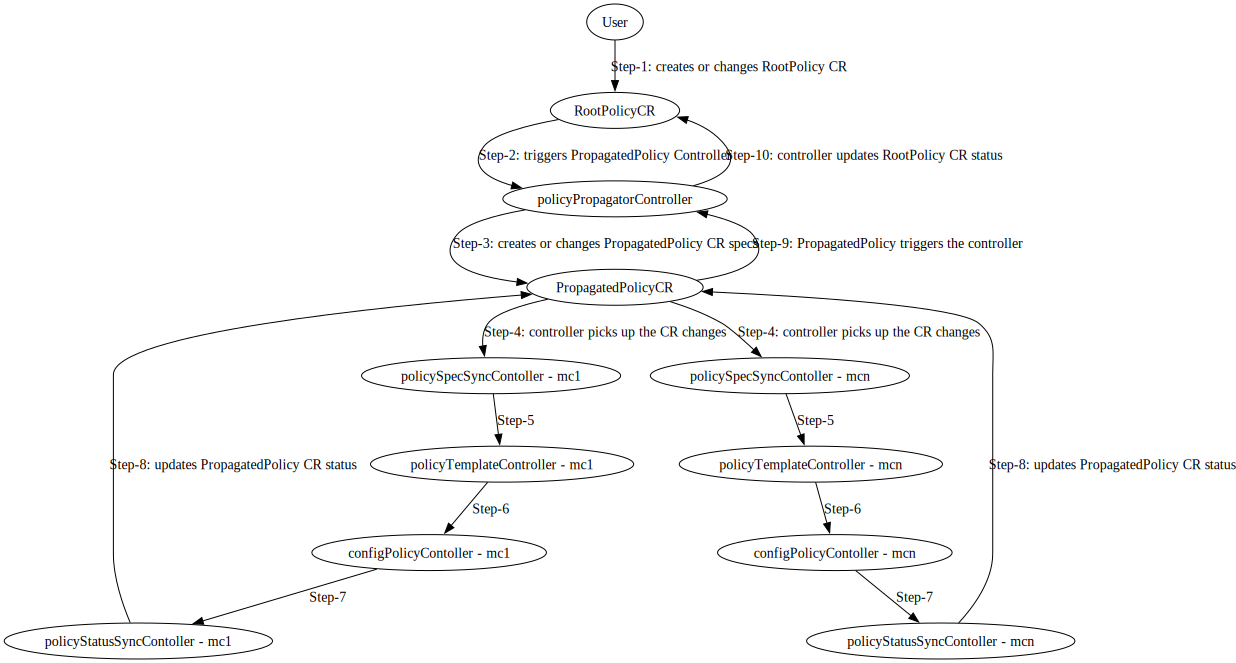

In [2]:

acmpolicycomplete=graphviz.Digraph()

acmpolicycomplete.edge('User','RootPolicyCR', label="Step-1: creates or changes RootPolicy CR")

acmpolicycomplete.edge('RootPolicyCR','policyPropagatorController', label="Step-2: triggers PropagatedPolicy Controller")


acmpolicycomplete.edge('policyPropagatorController','PropagatedPolicyCR', label="Step-3: creates or changes PropagatedPolicy CR specs")


acmpolicycomplete.edge('PropagatedPolicyCR','policySpecSyncContoller - mc1', label="Step-4: controller picks up the CR changes")
acmpolicycomplete.edge('PropagatedPolicyCR','policySpecSyncContoller - mcn', label="Step-4: controller picks up the CR changes")

acmpolicycomplete.edge('policySpecSyncContoller - mc1','policyTemplateController - mc1', label="Step-5")
acmpolicycomplete.edge('policySpecSyncContoller - mcn','policyTemplateController - mcn', label="Step-5")

acmpolicycomplete.edge('policyTemplateController - mc1','configPolicyContoller - mc1', label="Step-6")
acmpolicycomplete.edge('policyTemplateController - mcn','configPolicyContoller - mcn', label="Step-6")

acmpolicycomplete.edge('configPolicyContoller - mc1','policyStatusSyncContoller - mc1', label="Step-7")
acmpolicycomplete.edge('configPolicyContoller - mcn','policyStatusSyncContoller - mcn', label="Step-7")

acmpolicycomplete.edge('policyStatusSyncContoller - mc1','PropagatedPolicyCR', label="Step-8: updates PropagatedPolicy CR status")
acmpolicycomplete.edge('policyStatusSyncContoller - mcn','PropagatedPolicyCR', label="Step-8: updates PropagatedPolicy CR status")

acmpolicycomplete.edge('PropagatedPolicyCR','policyPropagatorController', label="Step-9: PropagatedPolicy triggers the controller")
acmpolicycomplete.edge('policyPropagatorController','RootPolicyCR', label="Step-10: controller updates RootPolicy CR status")

acmpolicycomplete

### Causal Mechanism at the Hub

The number of changes in the root policy specification is the reason that causes stress in the:
- root-policy-spec controller
- replicated-policy controller

The change metric is captured through:
- RateOfRootPolicySpecChange

The stress metric is captured through:
 - RootPolicySpecCtrlResponsePctle1sec
 - ReplicatedPolicyCtrlResponsePctle1sec

The number of changes in the propagated/replicated policy policy is the reason that causes the stress in the:
- root-policy-status controller 
- replicated-policy controller

The stress metric is captured through:
 - NonCompliantPropagatedPoliciesTotal

The stress is captured through:
- RootPolicyStatusCtrlResponsePctle1sec
- ReplicatedPolicyCtrlResponsePctle1sec

Visually this can be shown as below.


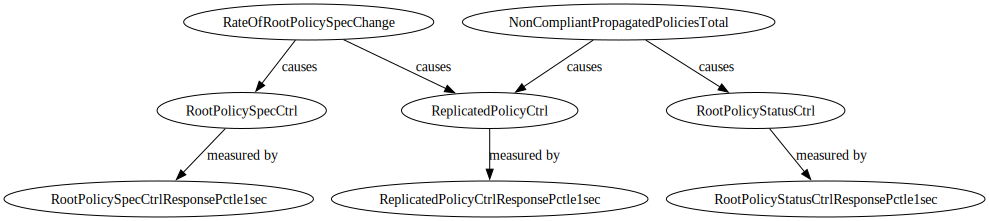

In [3]:
causal=graphviz.Digraph()

causal.edge('RateOfRootPolicySpecChange','RootPolicySpecCtrl', label="causes")
causal.edge('RateOfRootPolicySpecChange','ReplicatedPolicyCtrl',label="causes")

causal.edge('NonCompliantPropagatedPoliciesTotal','RootPolicyStatusCtrl', label="causes")
causal.edge('NonCompliantPropagatedPoliciesTotal','ReplicatedPolicyCtrl',label="causes")

causal.edge('RootPolicySpecCtrl','RootPolicySpecCtrlResponsePctle1sec',label="measured by")
causal.edge('RootPolicyStatusCtrl','RootPolicyStatusCtrlResponsePctle1sec', label="measured by")
causal.edge('ReplicatedPolicyCtrl','ReplicatedPolicyCtrlResponsePctle1sec',label="measured by")


causal

### Causal Metrics collected from acm-inspector

In [4]:
#/Users/jbanerje/code/acm-inspector/master.csv

#fname = os.path.join("/Users","jbanerje","code","acm-inspector","output","master.csv")
current_dir = os.getcwd()
fname = os.path.join(current_dir, "..","output","master.csv")
master_df = pandas.read_csv(fname,index_col=0)

#print(master_df.info())


In [5]:
grc_df = master_df[['ManagedClusterCount', 'RootPolicyCount', 'PropagatedtPolicyTotal',
                    'ReplicatedPolicyCtrlResponsePctle1sec','ReplicatedPolicyCtrlWorkQueueResponsePctle1sec',
                    'NonCompliantPropagatedPoliciesTotal','RateOfRootPolicySpecChange',
                    'RootPolicySpecCtrlResponsePctle1sec','RootPolicyStatusCtrlResponsePctle1sec']]
#grc_df.info()
#grc_df
#grc_df['RootPolicyStatusCtrlResponsePctle1sec'].describe()

grc_df.describe()
#grc_df['RootPolicyStatusCtrlResponsePctle1sec'].describe()
#grc_df.plot(y = 'RootPolicyStatusCtrlResponsePctle1sec')
#grc_df['RootPolicyStatusCtrlResponsePctle1sec'].plot.bar()


,ManagedClusterCount,RootPolicyCount,PropagatedtPolicyTotal,ReplicatedPolicyCtrlResponsePctle1sec,ReplicatedPolicyCtrlWorkQueueResponsePctle1sec,NonCompliantPropagatedPoliciesTotal,RateOfRootPolicySpecChange,RootPolicySpecCtrlResponsePctle1sec,RootPolicyStatusCtrlResponsePctle1sec
count,10080.000000,10080.000000,10080.000000,270.000000,270.000000,10080.000000,10080.000000,2.900000e+01,10080.000000
mean,12.011806,74.129266,115.102183,0.081473,0.011474,54.040278,0.000002,2.425000e-02,0.010712
std,0.108015,0.335511,1.201033,0.064236,0.019147,0.631203,0.000031,3.530858e-18,0.002516
min,12.000000,74.000000,104.000000,0.004750,0.000010,41.000000,0.000000,2.425000e-02,0.004995
25%,12.000000,74.000000,115.000000,0.047656,0.000925,54.000000,0.000000,2.425000e-02,0.009750
50%,12.000000,74.000000,115.000000,0.087500,0.000975,54.000000,0.000000,2.425000e-02,0.010810
75%,12.000000,74.000000,115.000000,0.096154,0.008650,54.000000,0.000000,2.425000e-02,0.011783
max,13.000000,75.000000,128.000000,0.228333,0.061000,63.000000,0.000575,2.425000e-02,0.024853


### Analyze Causal impact of RateOfRootPolicySpecChange

<Axes: xlabel='RateOfRootPolicySpecChange', ylabel='ReplicatedPolicyCtrlResponsePctle1sec'>

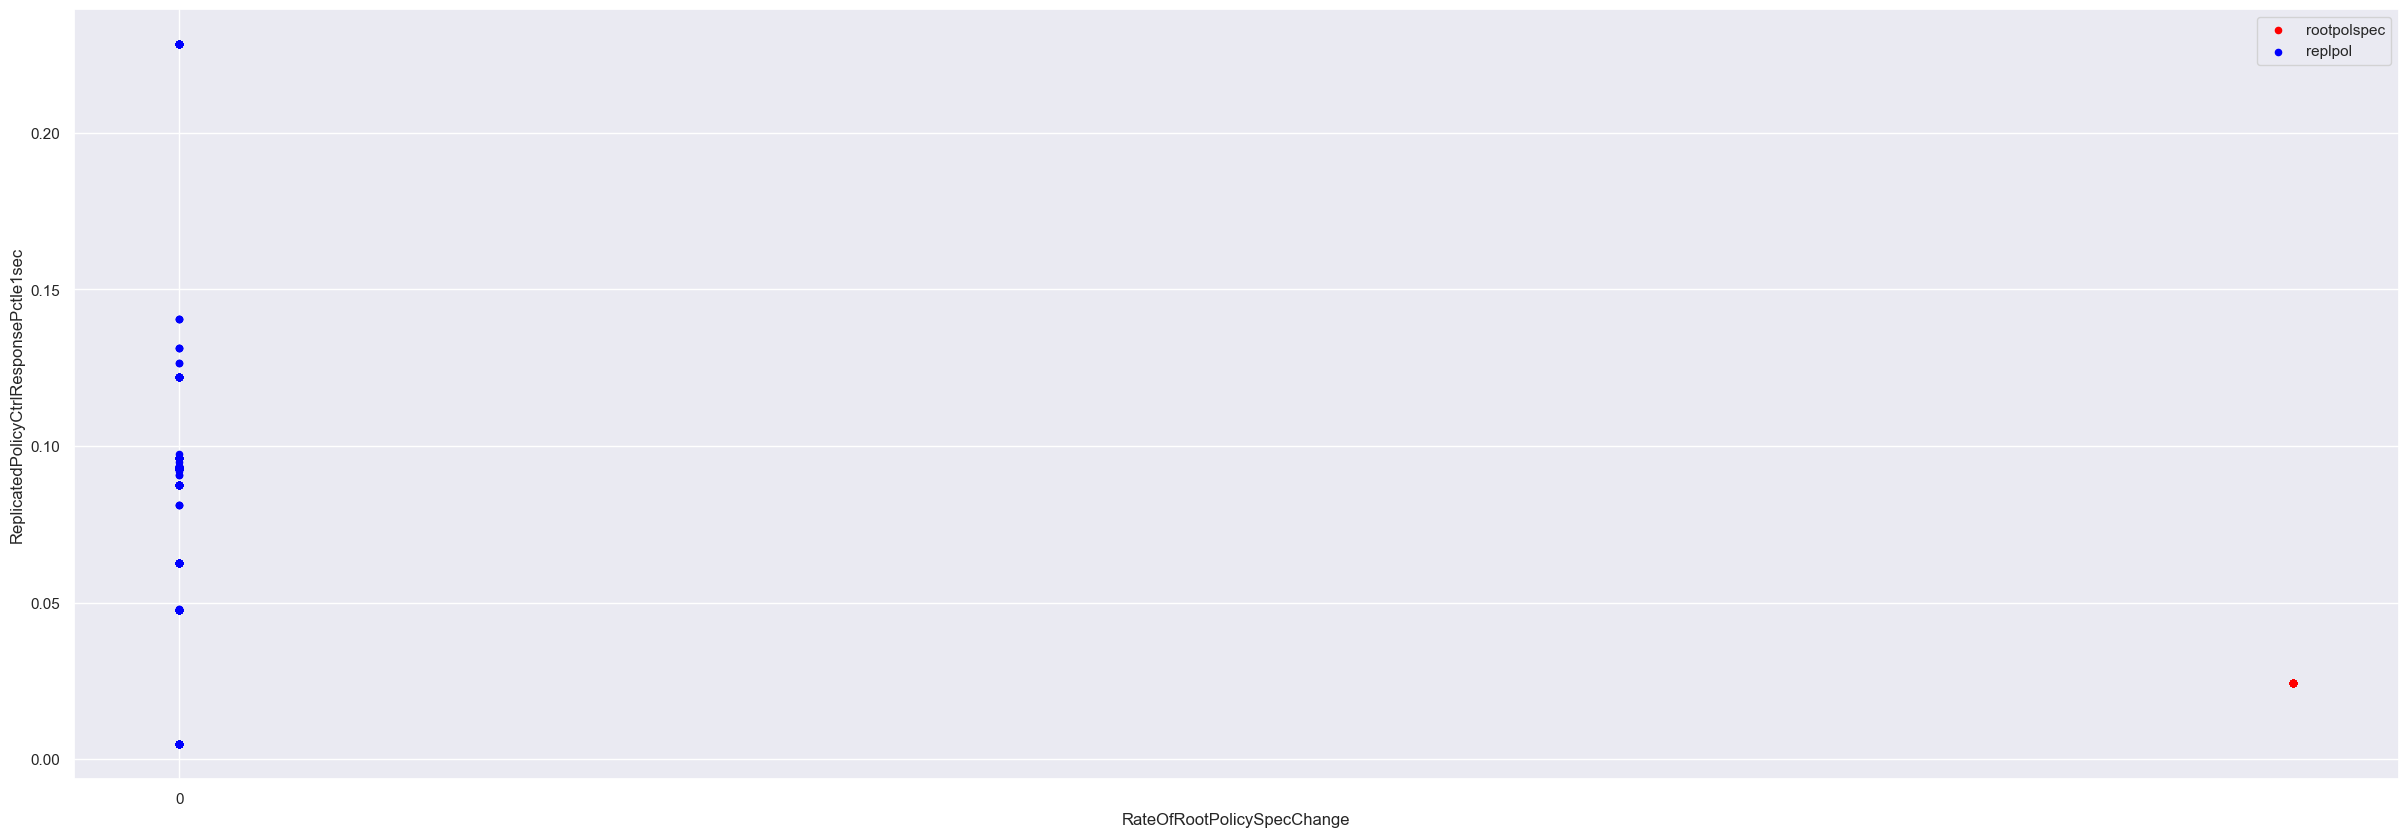

In [6]:
ax=grc_df.plot.scatter(x='RateOfRootPolicySpecChange', y='RootPolicySpecCtrlResponsePctle1sec',label='rootpolspec',s=20, c='red',xticks=[0,500,1000,1500])
grc_df.plot.scatter(x='RateOfRootPolicySpecChange', y='ReplicatedPolicyCtrlResponsePctle1sec',s=20,label='replpol', c='blue',ax=ax)

### Analyze Causal impact of NonCompliantPropagatedPoliciesTotal

<Axes: xlabel='NonCompliantPropagatedPoliciesTotal', ylabel='ReplicatedPolicyCtrlResponsePctle1sec'>

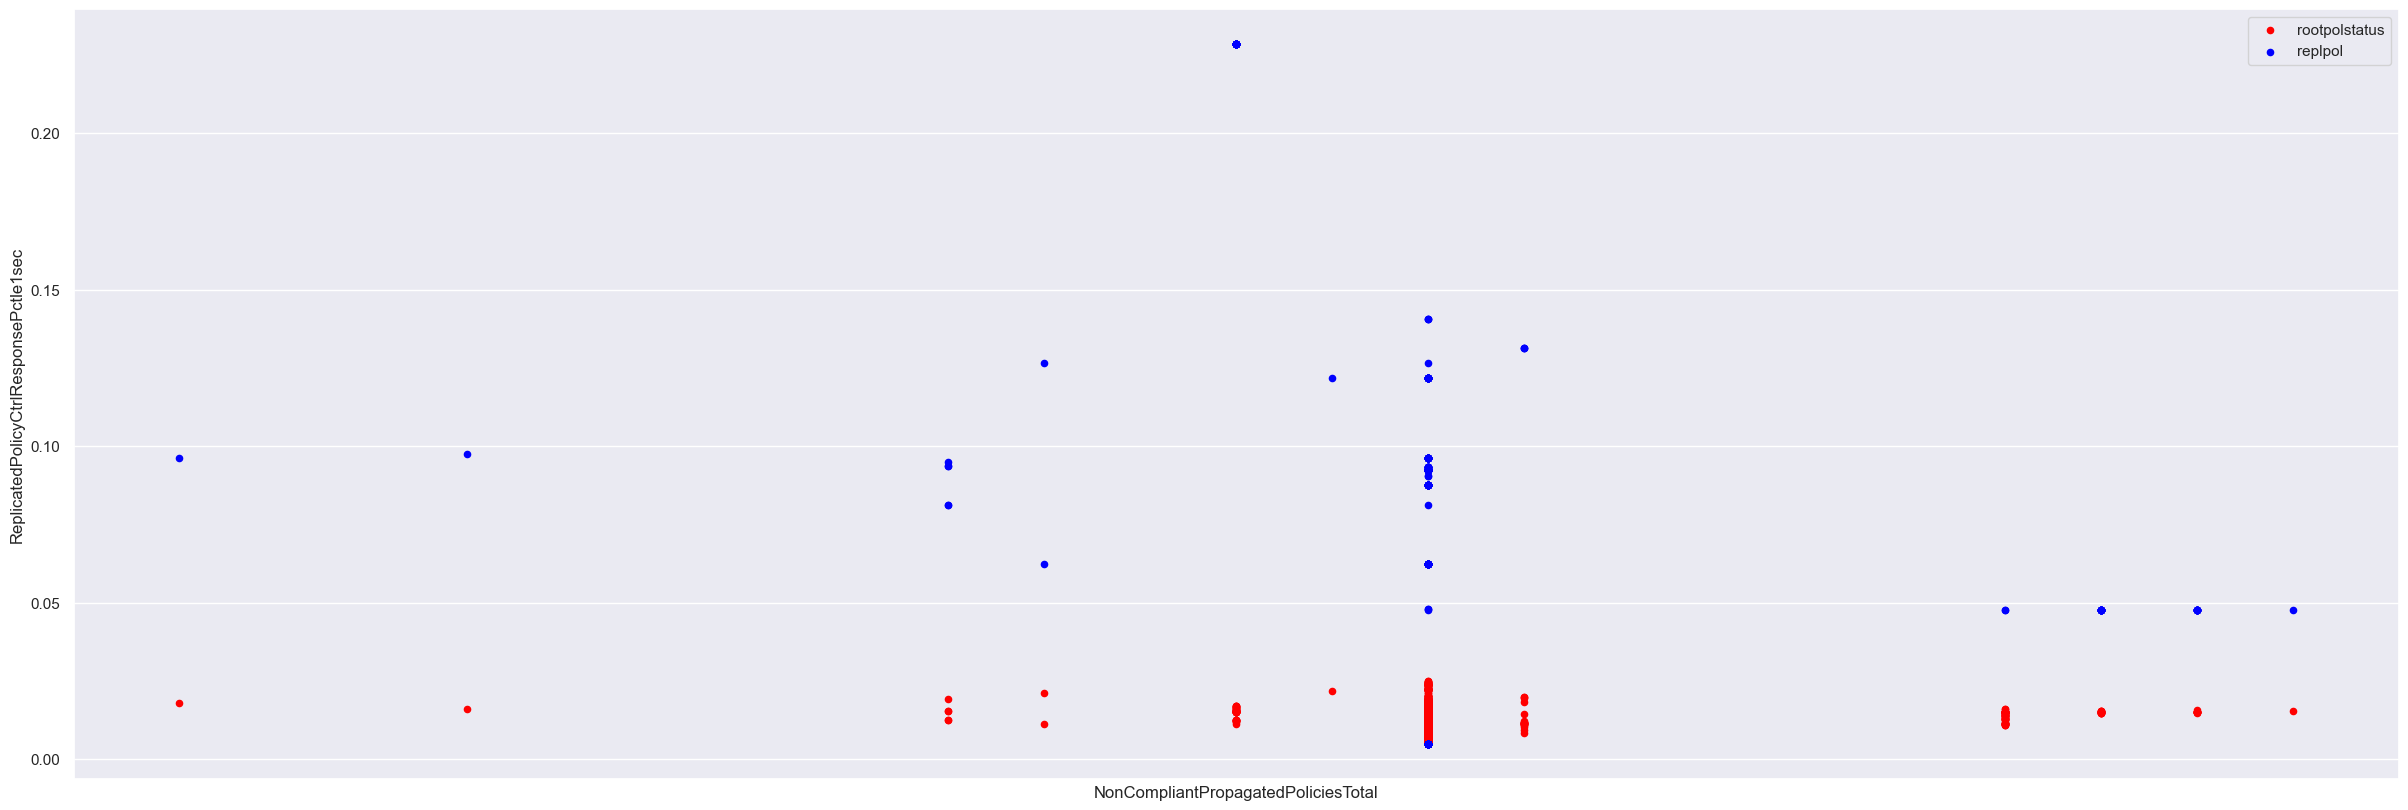

In [7]:
ax=grc_df.plot.scatter(x='NonCompliantPropagatedPoliciesTotal', y='RootPolicyStatusCtrlResponsePctle1sec',label='rootpolstatus',s=20, c='red',xticks=[0,500,1000,1500])
grc_df.plot.scatter(x='NonCompliantPropagatedPoliciesTotal', y='ReplicatedPolicyCtrlResponsePctle1sec',s=20,label='replpol', c='blue',ax=ax)

### Metrics that represent causes for Controller Stress

<Axes: xlabel='timestamp'>

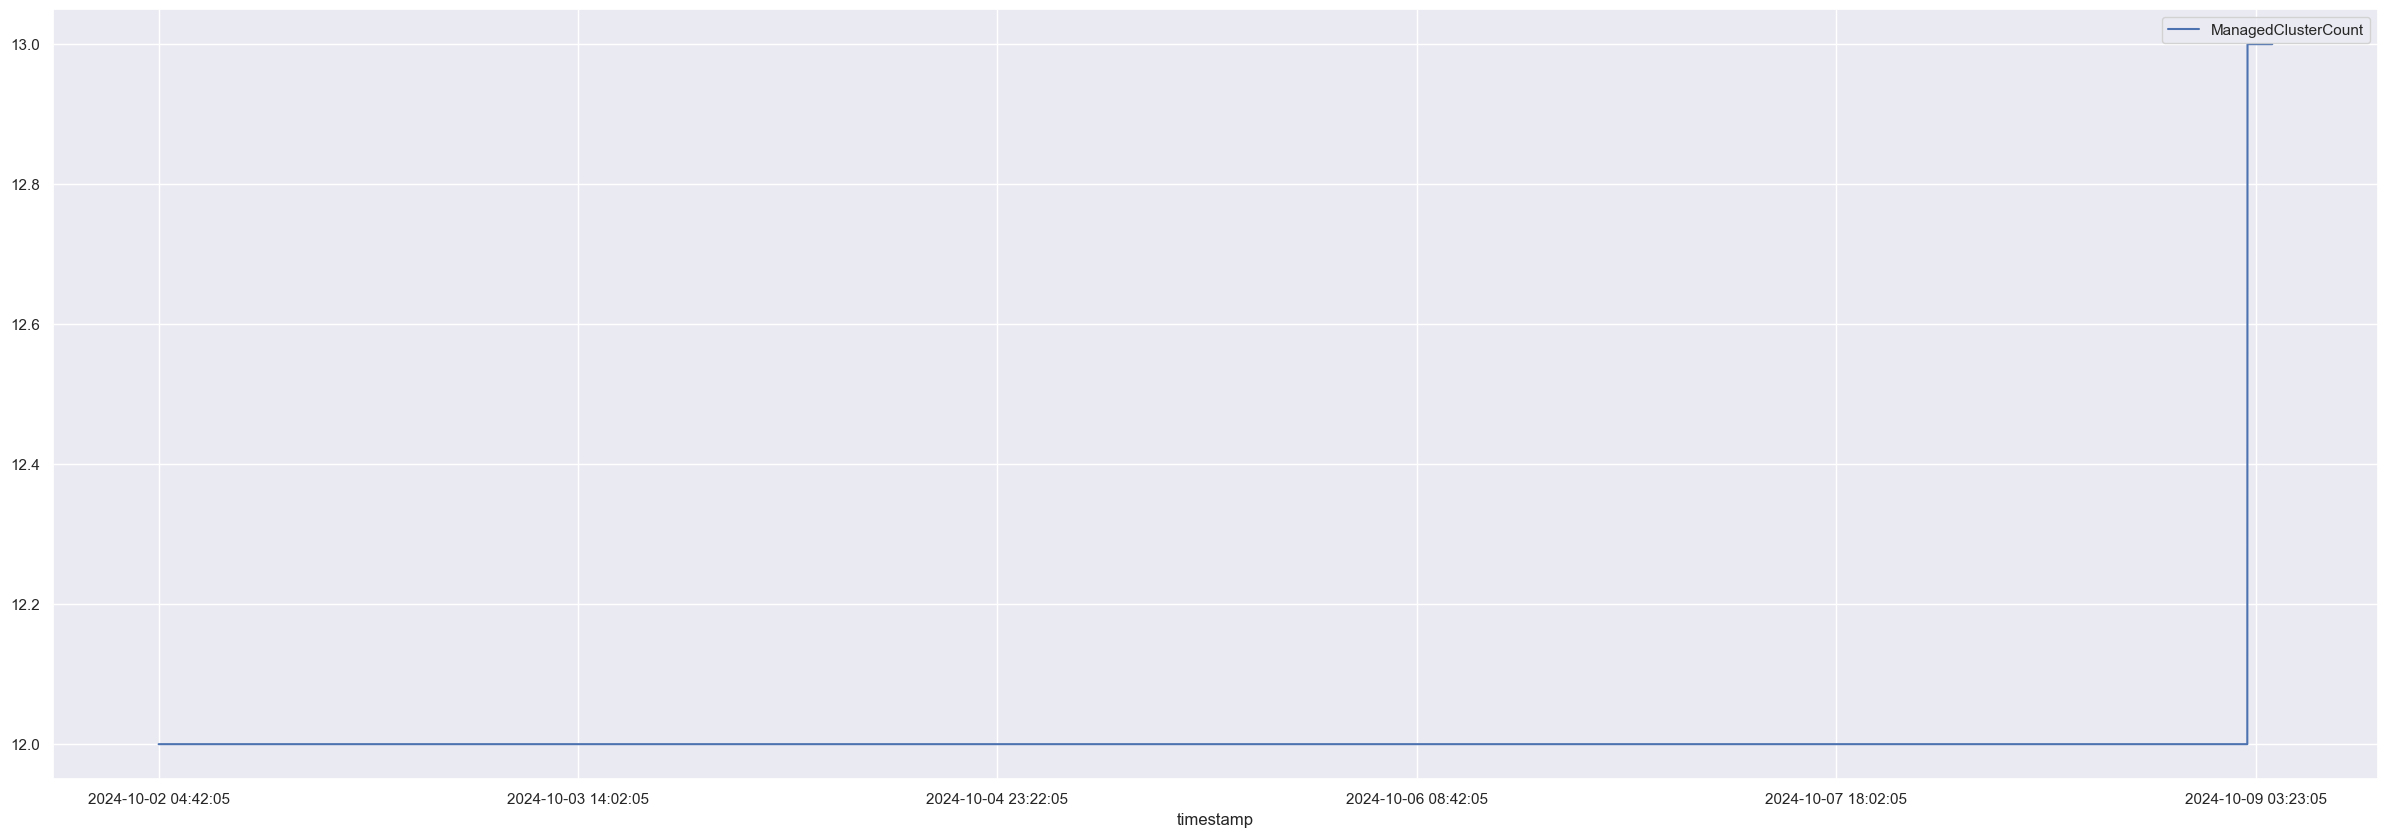

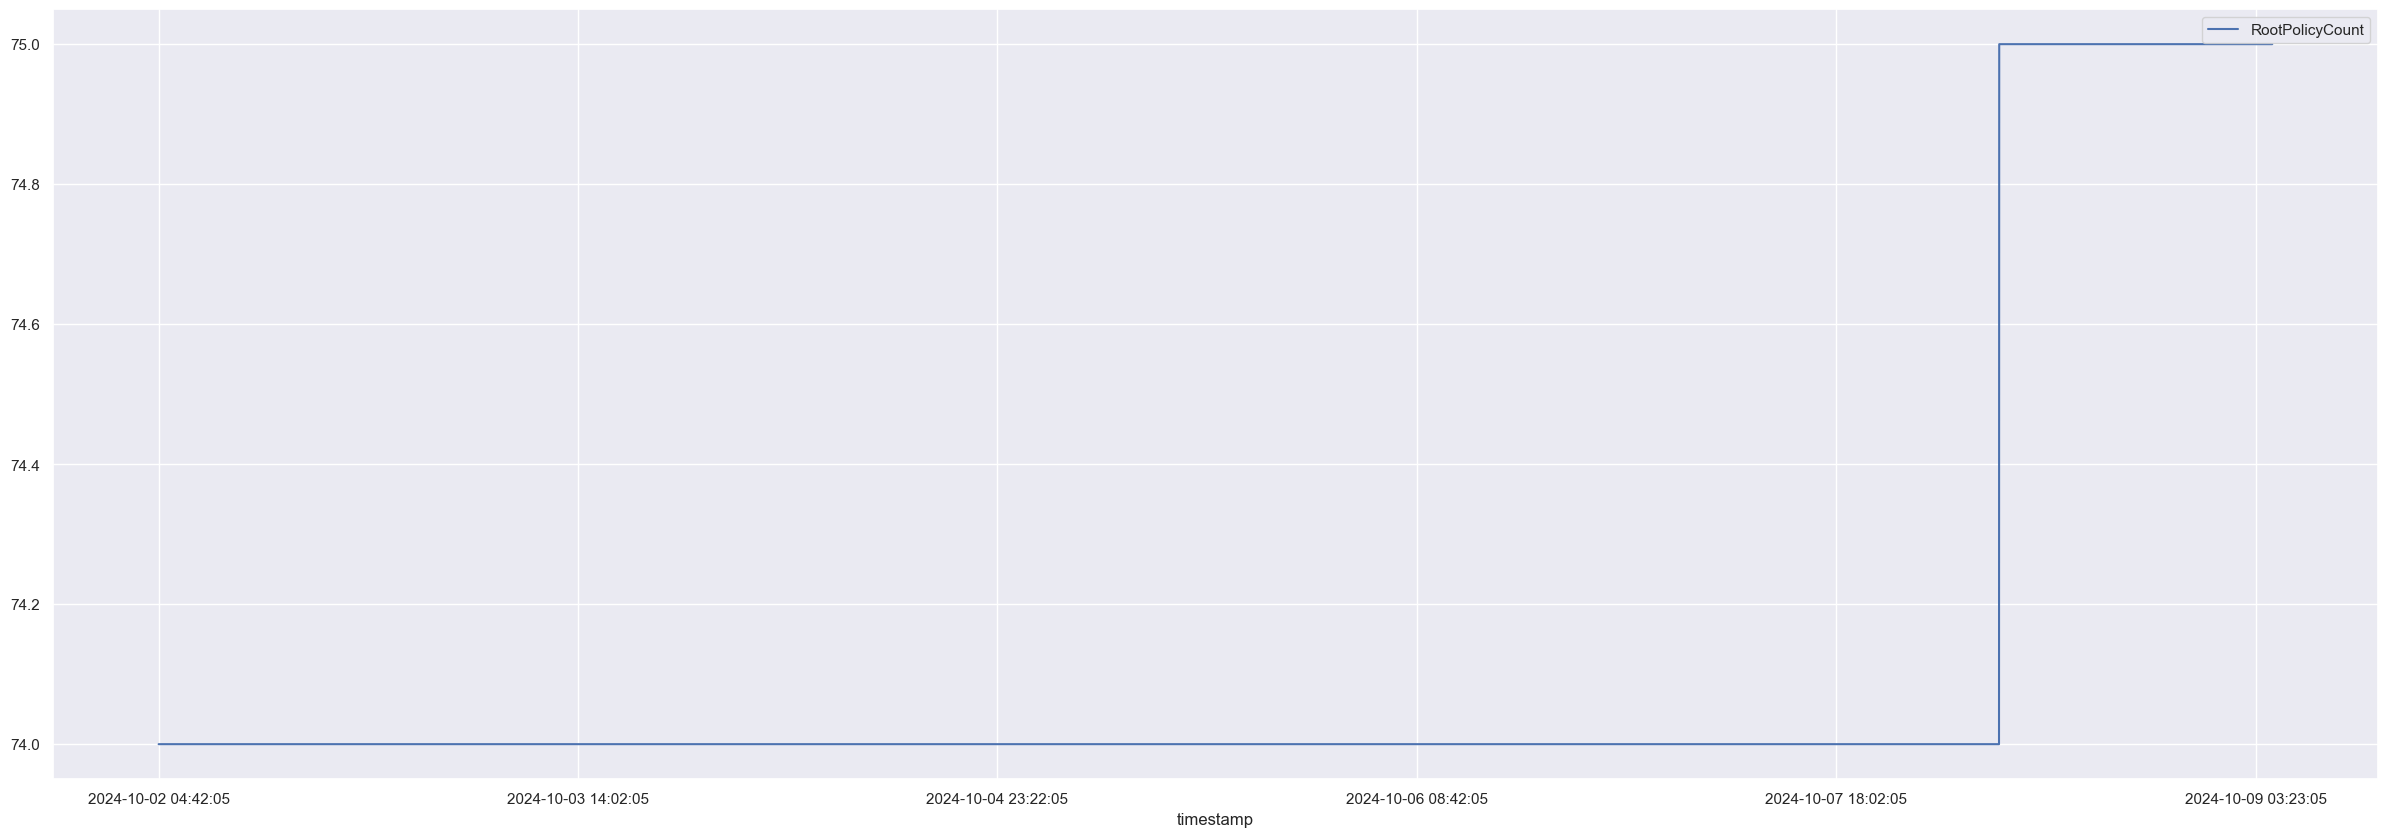

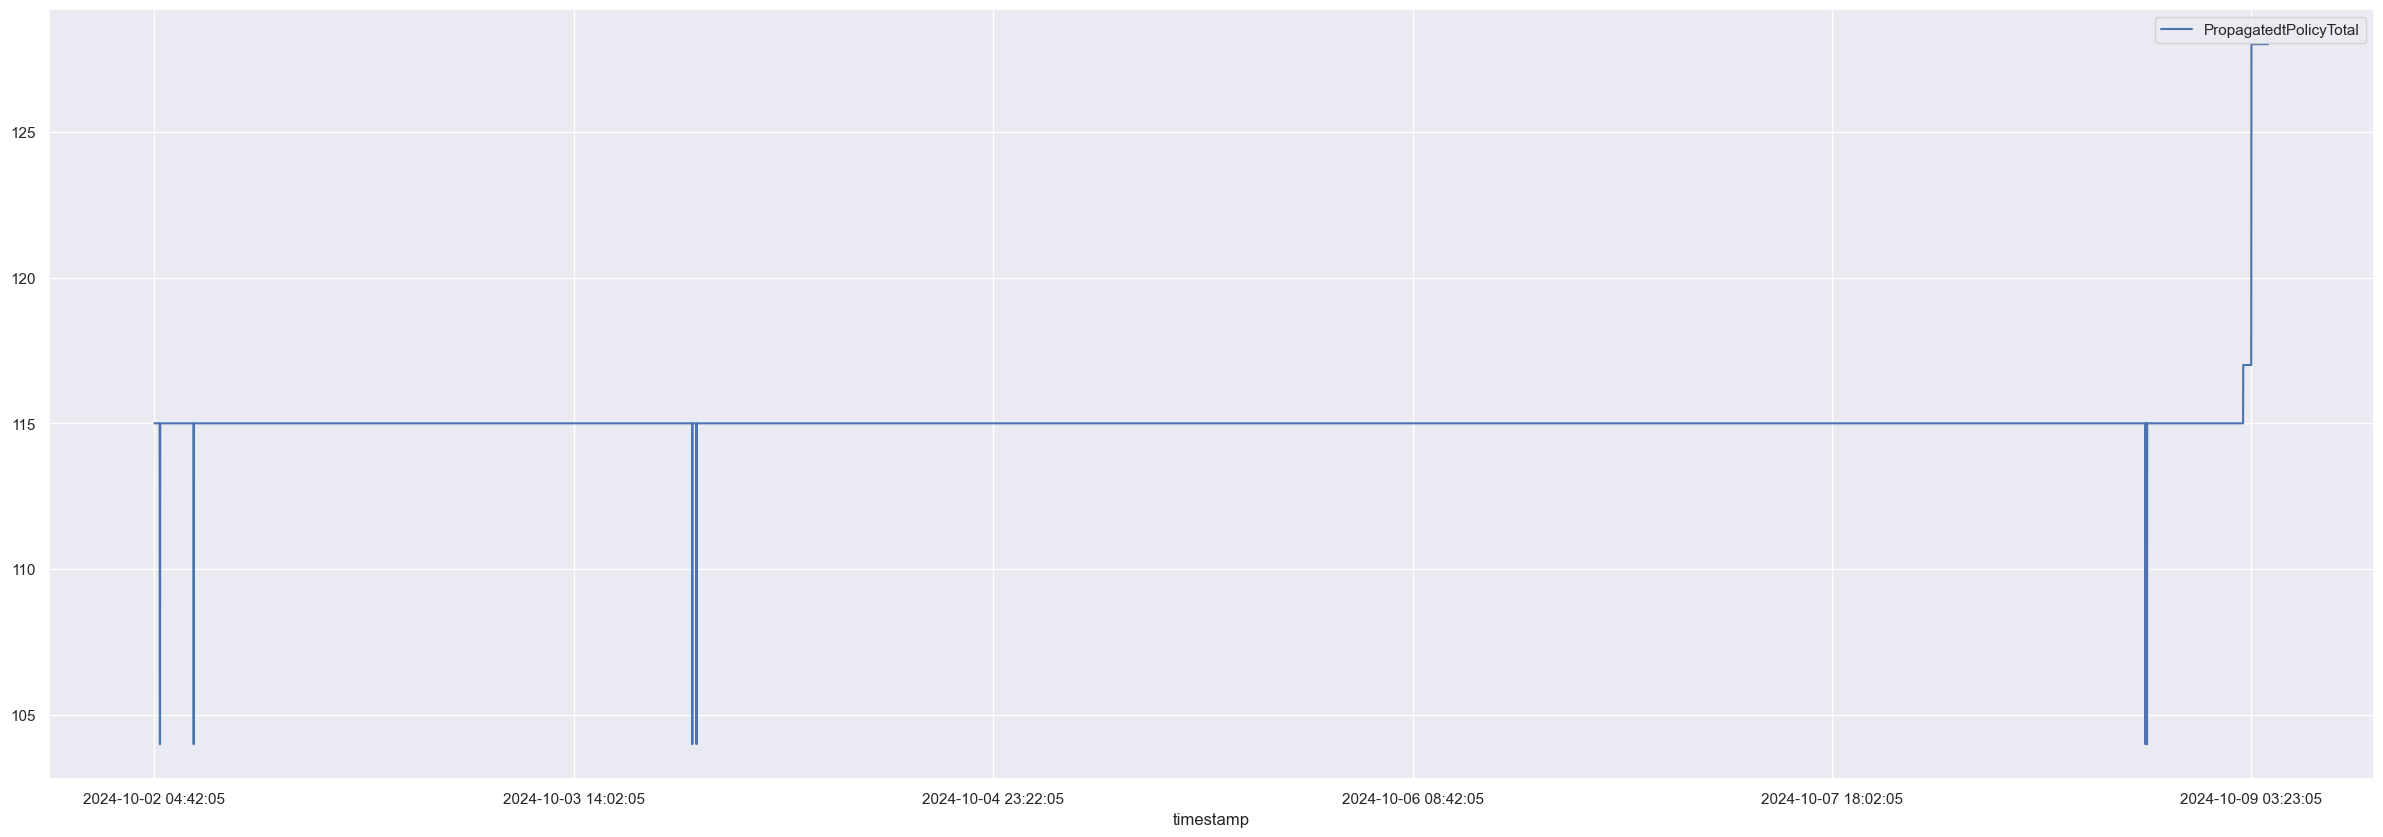

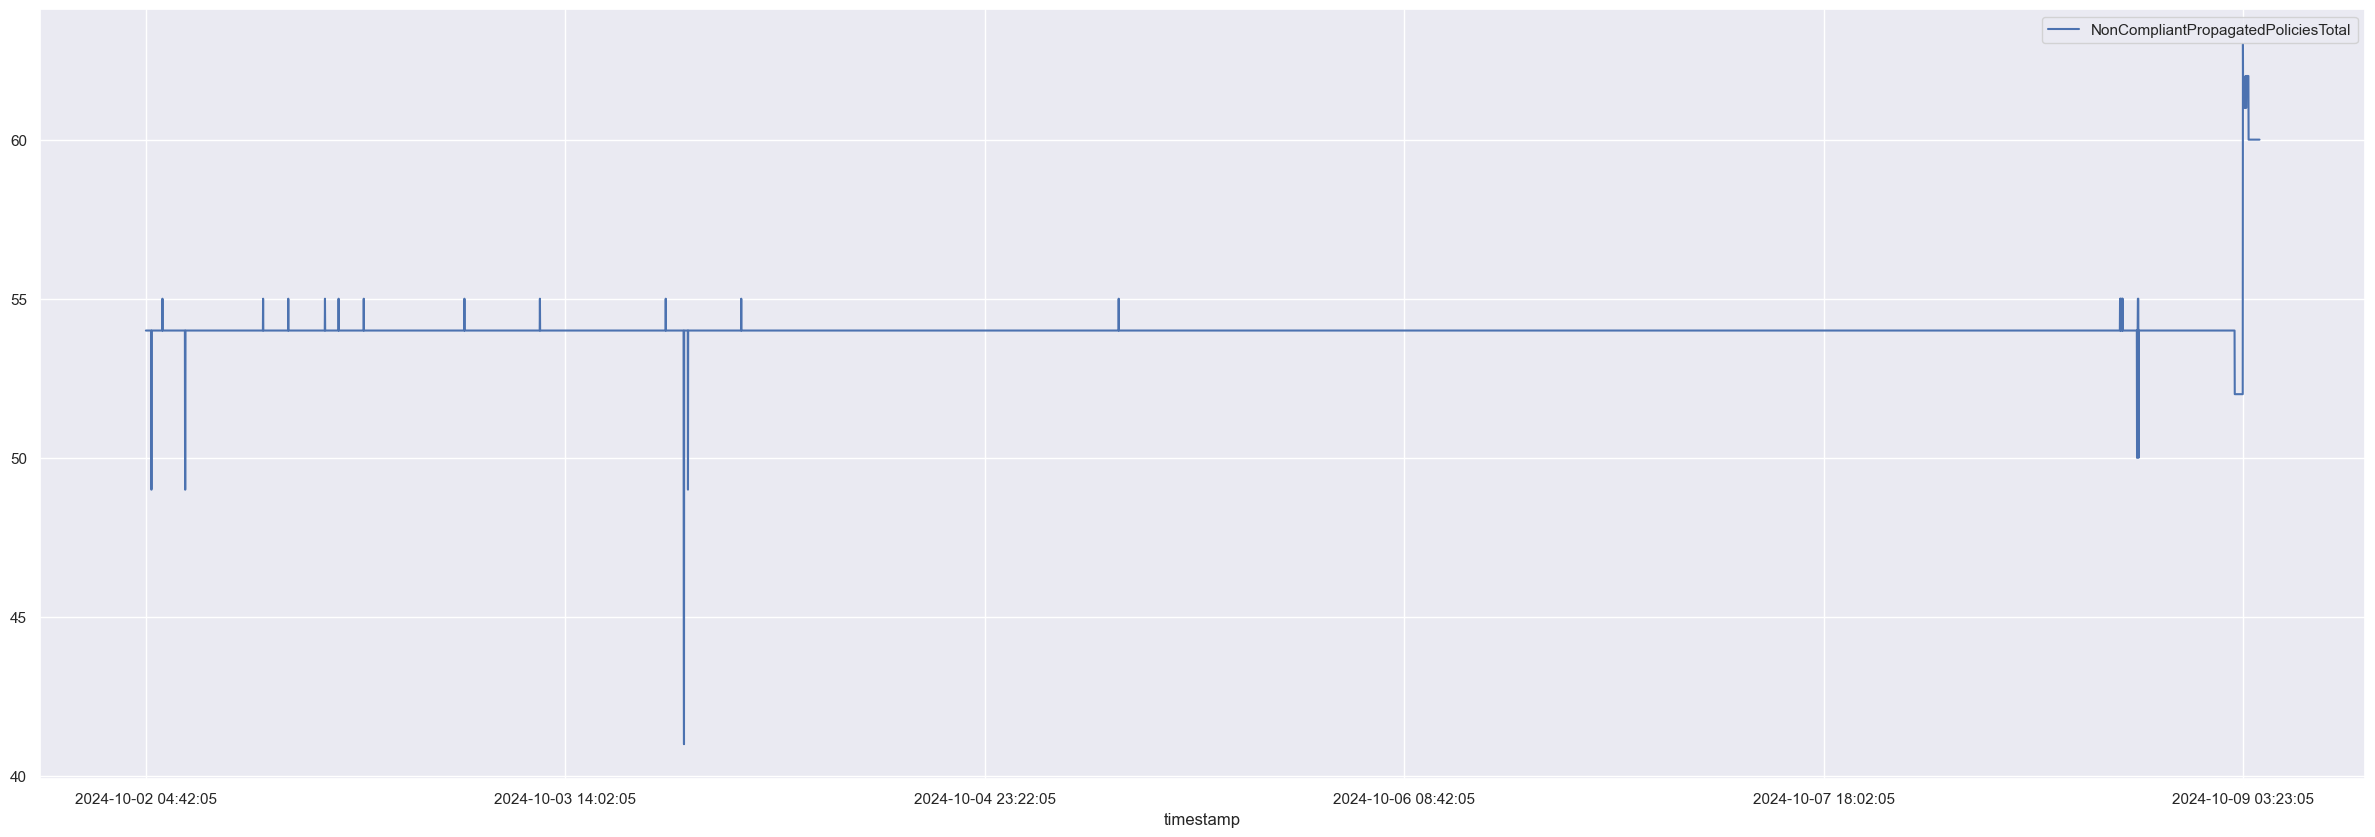

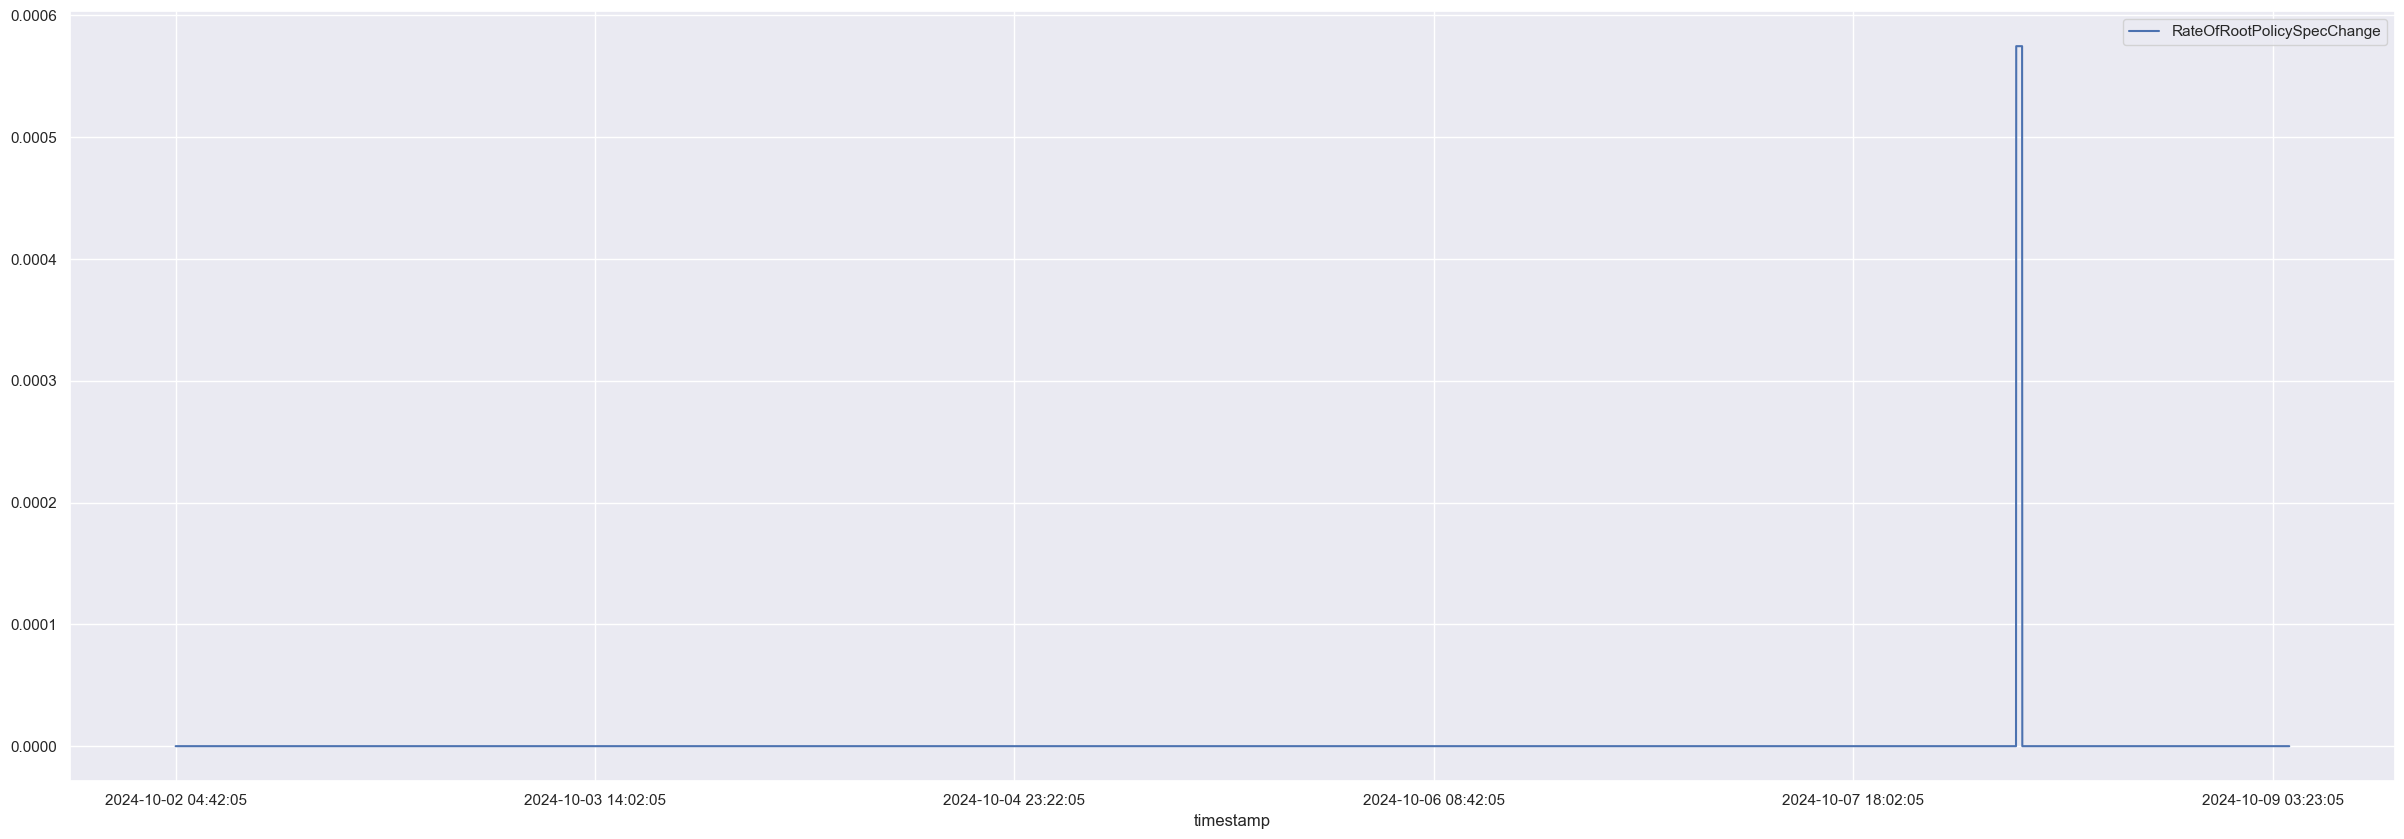

In [8]:
grc_df.plot(y = 'ManagedClusterCount')
grc_df.plot(y = 'RootPolicyCount')
grc_df.plot(y = 'PropagatedtPolicyTotal')

grc_df.plot(y = 'NonCompliantPropagatedPoliciesTotal')
grc_df.plot(y = 'RateOfRootPolicySpecChange')



### Metrics that identify Stress in Replicated Policy Controller

<Axes: xlabel='timestamp'>

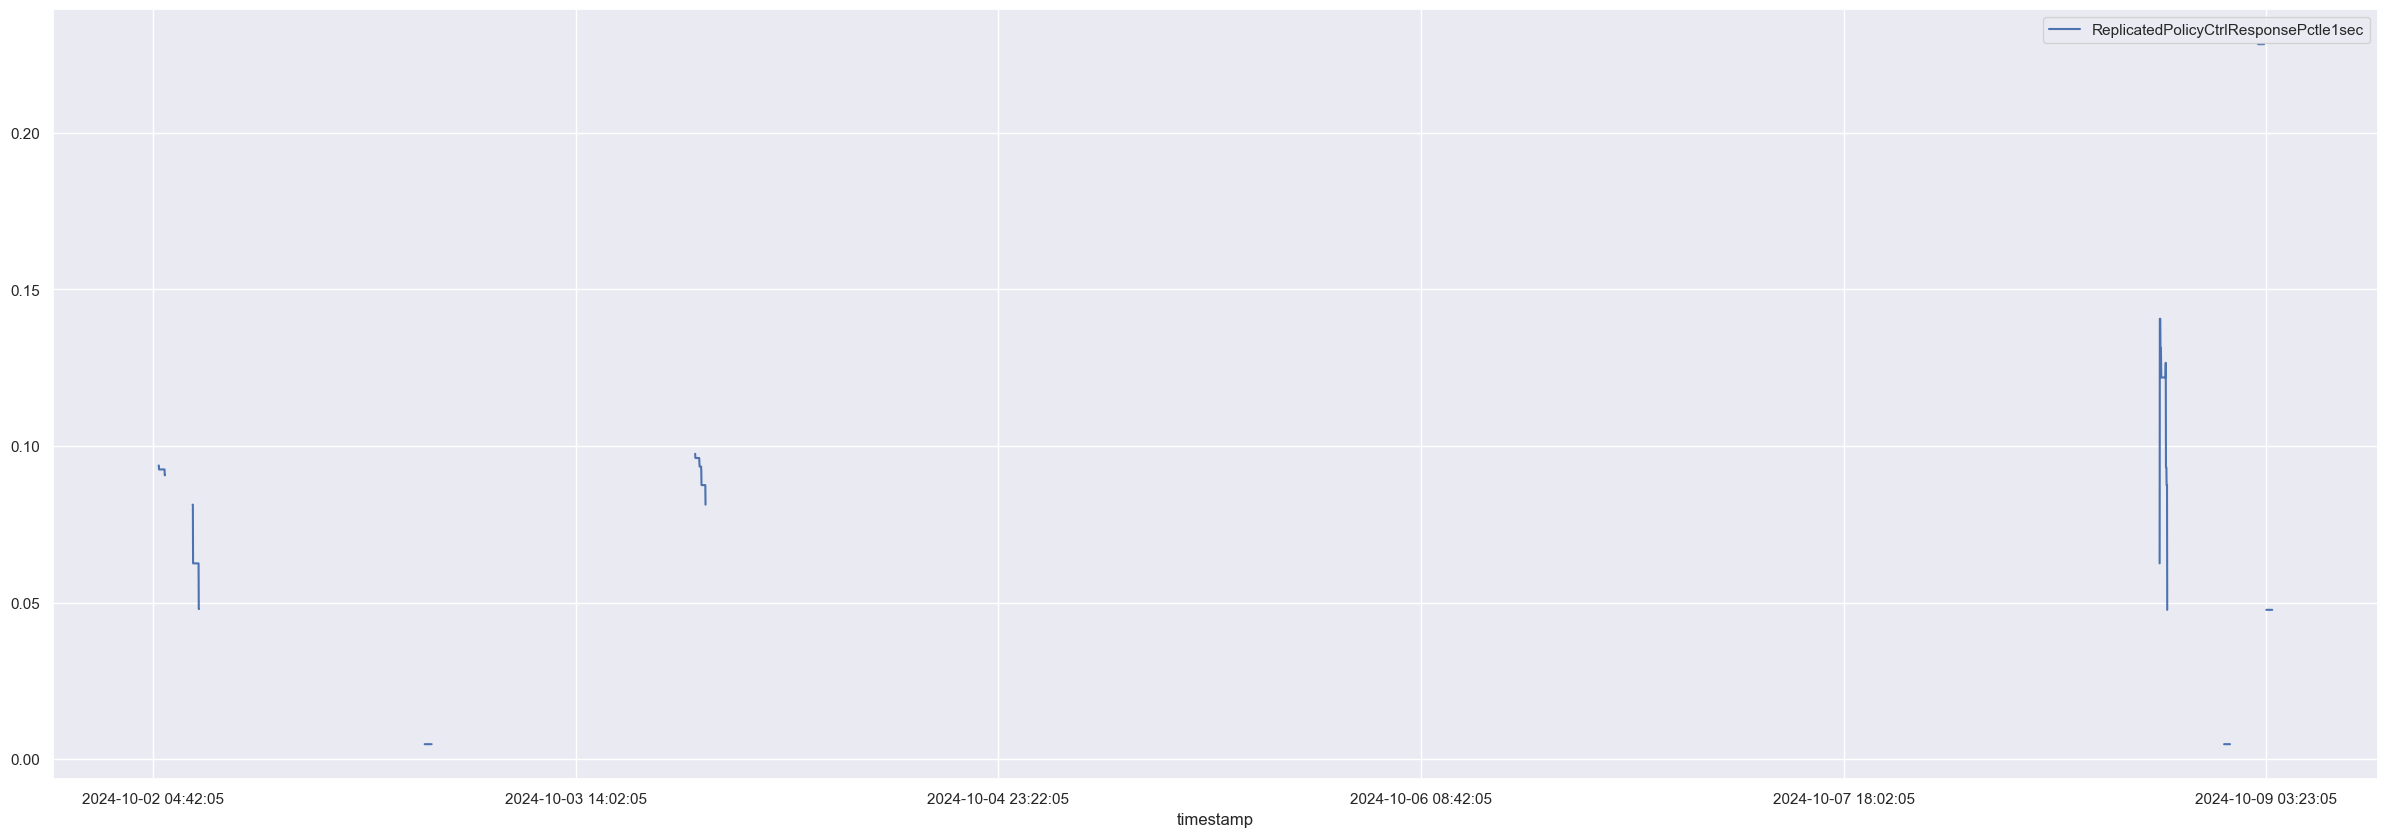

In [9]:
grc_df.plot(y = 'ReplicatedPolicyCtrlResponsePctle1sec')


### Metrics that identify Stress in Root PolicySpec Controller

<Axes: xlabel='timestamp'>

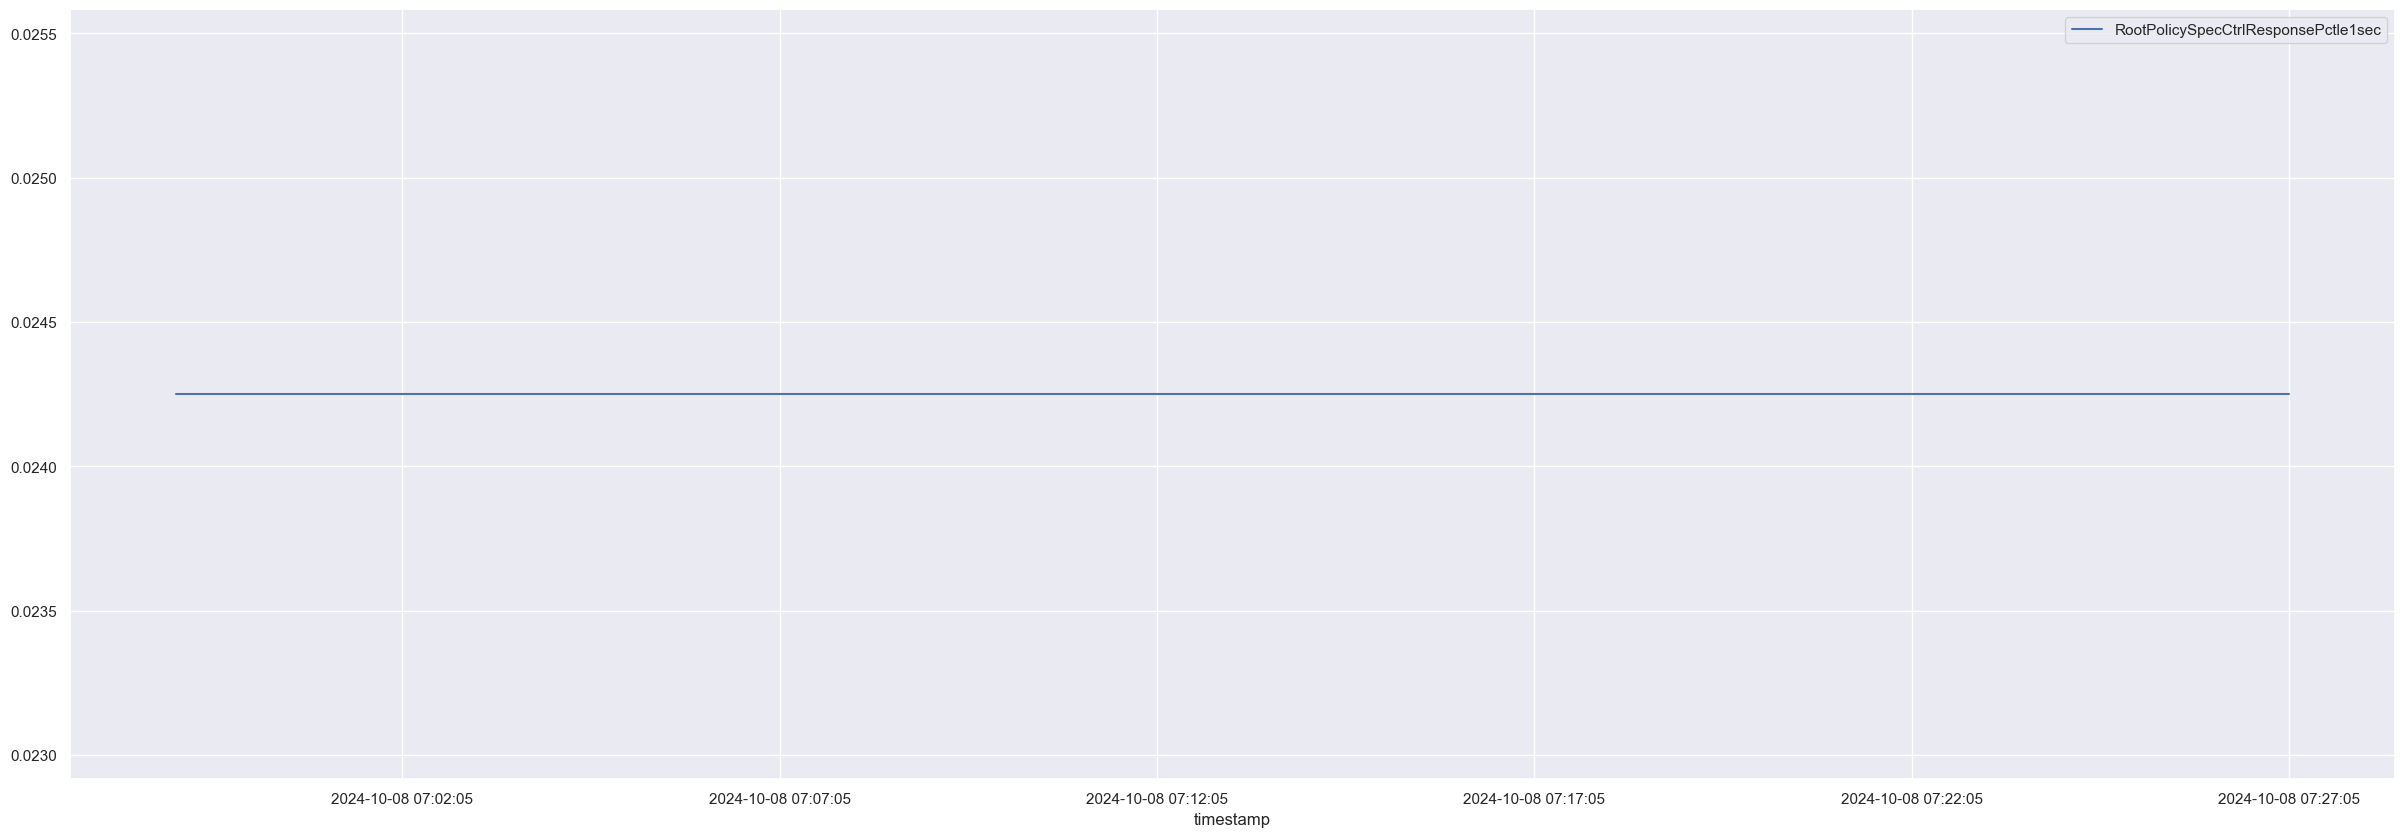

In [10]:
grc_df.plot(y = 'RootPolicySpecCtrlResponsePctle1sec')

### Metrics that identify Stress in Root PolicyStatus Controller

<Axes: xlabel='timestamp'>

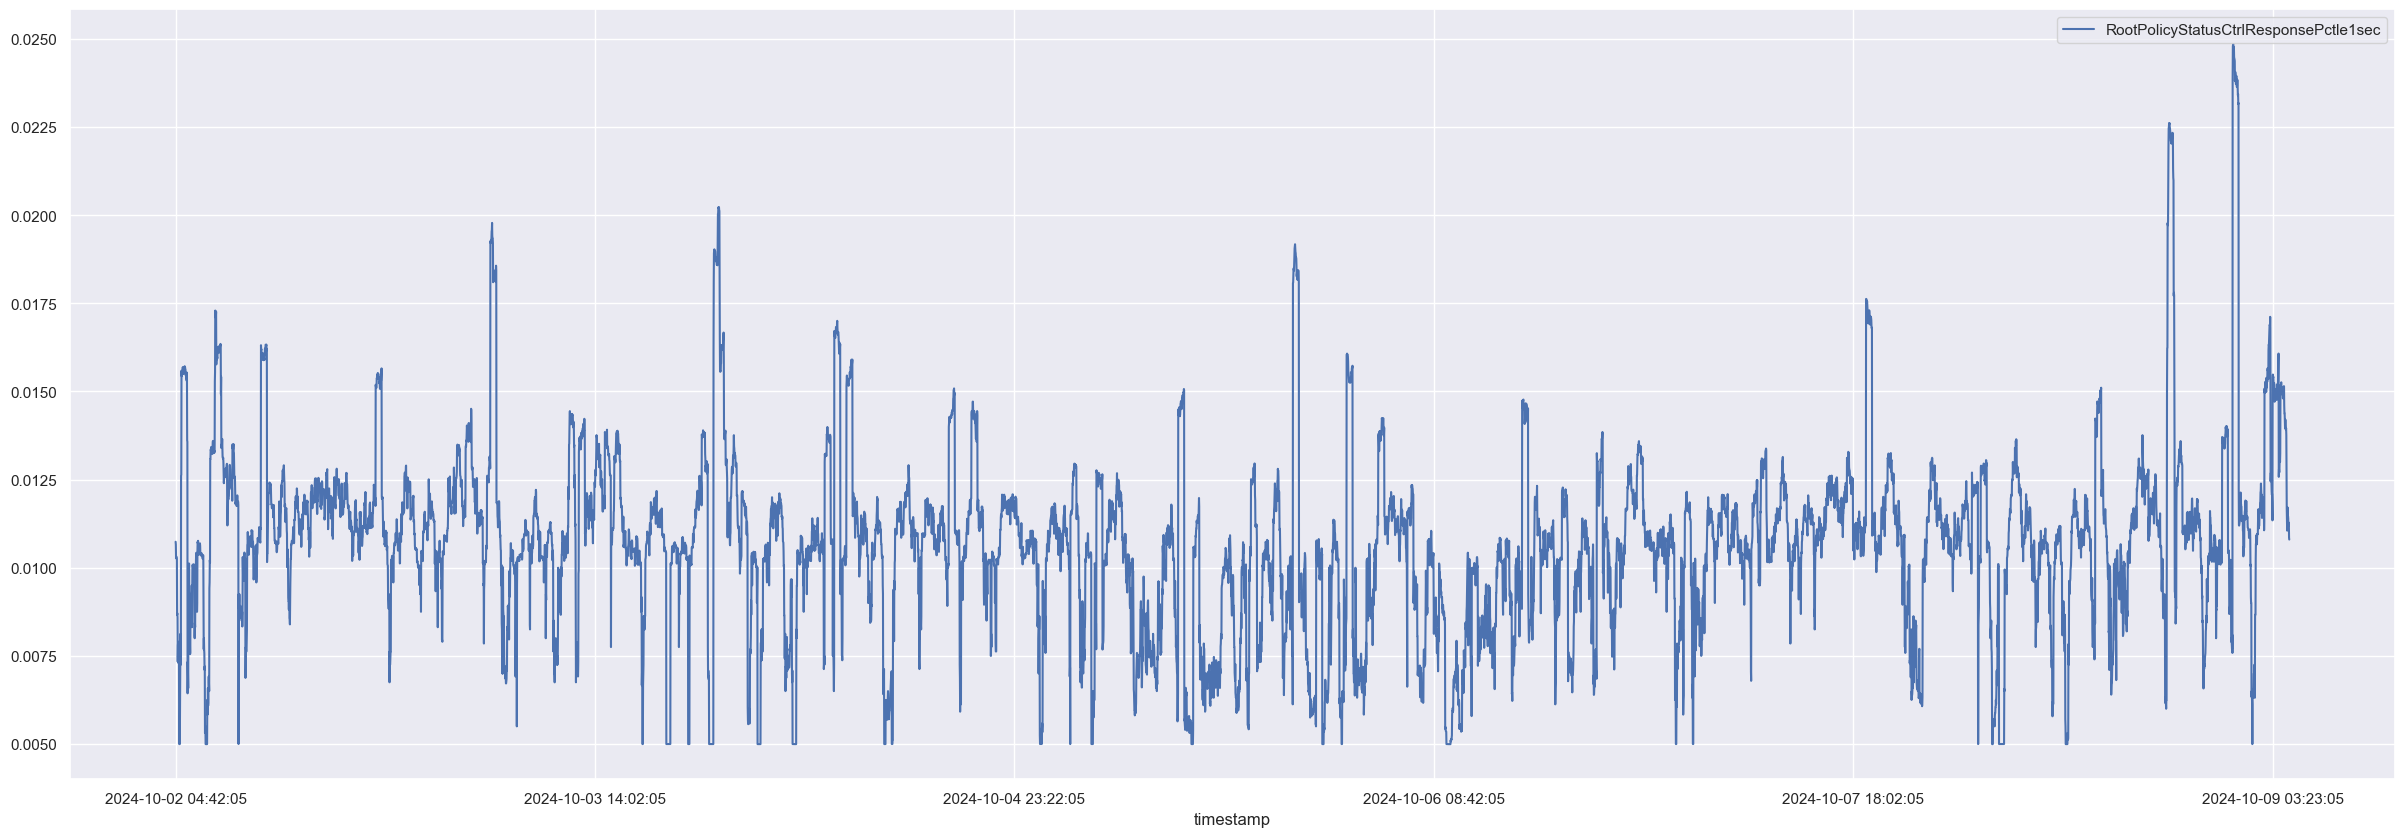

In [11]:
grc_df.plot(y = 'RootPolicyStatusCtrlResponsePctle1sec')

# Conclusion

After this causal analysis done above, we will know what causes the problem/stress - if there exists some issue.

Examine the impacted metrics - ie metrics that represent stress on the system:
1. Is there a trend in the metric that shows it shows it is rising
1. Has the metric value exceeded the usual threshold a large number of times


In [12]:
impacted_metrics = ['ReplicatedPolicyCtrlResponsePctle1sec',
                    'RootPolicySpecCtrlResponsePctle1sec',
                    'RootPolicyStatusCtrlResponsePctle1sec' ]

In [13]:
def checkIfTrendIsRising(metric):
    # A little bit of regression and then check slope
    # We may have to change boolean to a value
    return False


In [14]:
def checkIfValueIsHigh(metric):
    # How many times have this exceeded over a given value
    # How many observations in total
    # Therefore conclude ....
    # We may have to change boolean to a value
    return False

In [15]:
columns = ['MetricName', 'TrendProblem', 'ThresholdProblem']
conclusion_df = pandas.DataFrame(columns=columns)

for metric in impacted_metrics:
    
    trend=checkIfTrendIsRising(metric)
    threshold=checkIfValueIsHigh(metric)
    
    row = pandas.DataFrame([[metric, trend, threshold]], columns=columns)
    conclusion_df = pandas.concat([conclusion_df, row], ignore_index=True)

print("In Conclusion...")    
conclusion_df

In Conclusion...


,MetricName,TrendProblem,ThresholdProblem
0,ReplicatedPolicyCtrlResponsePctle1sec,False,False
1,RootPolicySpecCtrlResponsePctle1sec,False,False
2,RootPolicyStatusCtrlResponsePctle1sec,False,False


## Deeper Validation

1. Does root policy changes affect the controller performance
1. Does replicated policy change - coming from managed cluster - affect the controller performance
1. Does controller performance depend on
    1. managed cluster count
    1. total number of root policies
    1. total number of replicated policies
1. Viewing the related time series together


In [16]:
deeper_validation = False

### Does root policy changes affect the controller performance

In [17]:
if deeper_validation:
    root_policy = sns.pairplot(grc_df, x_vars=['ReplicatedPolicyCtrlResponsePctle1sec','RootPolicySpecCtrlResponsePctle1sec'], y_vars='RateOfRootPolicySpecChange', height=7, aspect=1)


### Does replicated policy change - coming from managed cluster - affect the controller performance

In [18]:
if deeper_validation:
    replicated_policy = sns.pairplot(grc_df, x_vars=['ReplicatedPolicyCtrlResponsePctle1sec','RootPolicyStatusCtrlResponsePctle1sec'], y_vars='NonCompliantPropagatedPoliciesTotal', height=7, aspect=1)


### Does controller performance depend on 
- managed cluster count
- total number of root policies
- total number of replicated policies

In [19]:
#'ManagedClusterCount', 'RootPolicyCount', 'PropagatedtPolicyTotal'

if deeper_validation:
    dep_managedcluster = sns.pairplot(grc_df, x_vars=['RootPolicyStatusCtrlResponsePctle1sec','RootPolicySpecCtrlResponsePctle1sec','ReplicatedPolicyCtrlResponsePctle1sec','ReplicatedPolicyCtrlWorkQueueResponsePctle1sec'], y_vars='ManagedClusterCount', height=7, aspect=1)
    dep_rootpolicycount = sns.pairplot(grc_df, x_vars=['RootPolicyStatusCtrlResponsePctle1sec','RootPolicySpecCtrlResponsePctle1sec','ReplicatedPolicyCtrlResponsePctle1sec','ReplicatedPolicyCtrlWorkQueueResponsePctle1sec'], y_vars='RootPolicyCount', height=7, aspect=1)
    dep_proppolicycount = sns.pairplot(grc_df, x_vars=['RootPolicyStatusCtrlResponsePctle1sec','RootPolicySpecCtrlResponsePctle1sec','ReplicatedPolicyCtrlResponsePctle1sec','ReplicatedPolicyCtrlWorkQueueResponsePctle1sec'], y_vars='PropagatedtPolicyTotal', height=7, aspect=1)


### Viewing the related time series together

In [20]:
#grc_df.plot(title="Count of Root Policies",figsize=(30, 15))
#grc_df.plot()

if deeper_validation:
    grc_df.plot(y = 'ManagedClusterCount')
    grc_df.plot(y = 'RootPolicyCount')
    grc_df.plot(y = 'PropagatedtPolicyTotal')

    grc_df.plot(y = 'NonCompliantPropagatedPoliciesTotal')
    grc_df.plot(y = 'ReplicatedPolicyCtrlResponsePctle1sec')
    grc_df.plot(y = 'ReplicatedPolicyCtrlWorkQueueResponsePctle1sec')


    grc_df.plot(y = 'RateOfRootPolicySpecChange')
    grc_df.plot(y = 'RootPolicySpecCtrlResponsePctle1sec')
    grc_df.plot(y = 'RootPolicyStatusCtrlResponsePctle1sec')



In [21]:
fname = os.path.join("/Users","jbanerje","code","acm-inspector","output","policy-root-ctrl-status-le1sec-count.csv")
temp_df = pandas.read_csv(fname,index_col=0)

temp_df

,RootPolicyStatusCtrlResponsePctle1sec
timestamp,
2024-10-02 04:42:05,0.010737
2024-10-02 04:43:05,0.010658
2024-10-02 04:44:05,0.010268
2024-10-02 04:45:05,0.010321
2024-10-02 04:46:05,0.010295
...,...
2024-10-09 04:38:05,0.011180
2024-10-09 04:39:05,0.011198
2024-10-09 04:40:05,0.011279


<Axes: xlabel='timestamp'>

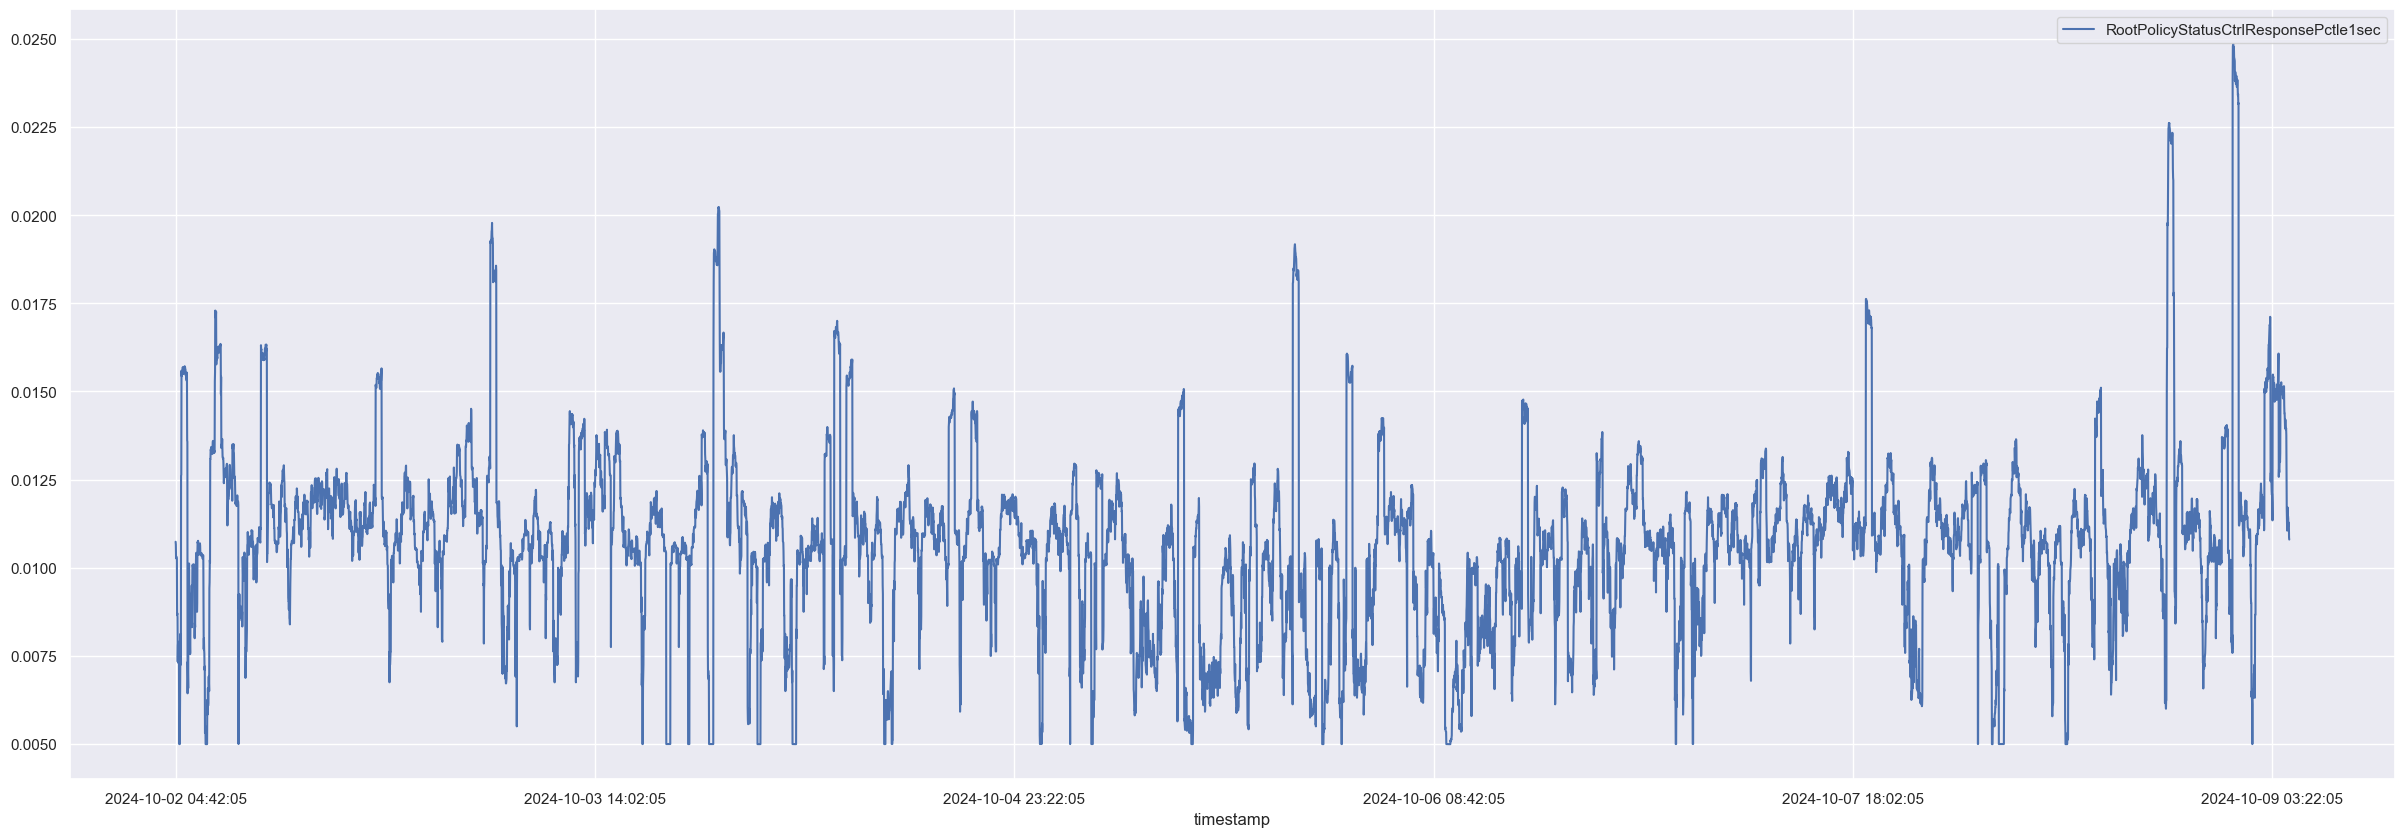

In [22]:
temp_df.plot(y = 'RootPolicyStatusCtrlResponsePctle1sec')
#plt.ylim(0, 1)  # X-axis limit

In [23]:
#temp_df['RootPolicyStatusCtrlResponsePctle1sec'] = temp_df['RootPolicyStatusCtrlResponsePctle1sec'] * 10

# Mean
mean_value = temp_df['RootPolicyStatusCtrlResponsePctle1sec'].mean()
print(f'Mean: {mean_value}')

# Median
median_value = temp_df['RootPolicyStatusCtrlResponsePctle1sec'].median()
print(f'Median: {median_value}')

# Max
max_value = temp_df['RootPolicyStatusCtrlResponsePctle1sec'].max()
print(f'Max: {median_value}')

# Min
min_value = temp_df['RootPolicyStatusCtrlResponsePctle1sec'].min()
print(f'Min: {min_value}')

# Mode
mode_value = temp_df['RootPolicyStatusCtrlResponsePctle1sec'].mode()
print(f'Mode: {mode_value.values}')  # Mode can return multiple values

# Variance
variance_value = temp_df['RootPolicyStatusCtrlResponsePctle1sec'].var()
print(f'Variance: {variance_value}')

# Standard Deviation
std_dev_value = temp_df['RootPolicyStatusCtrlResponsePctle1sec'].std()
print(f'Standard Deviation: {std_dev_value}')

Mean: 0.010712455396605768
Median: 0.0108104838709677
Max: 0.0108104838709677
Min: 0.0049946714031971
Mode: [0.01]
Variance: 6.330635416160005e-06
Standard Deviation: 0.00251607539953794


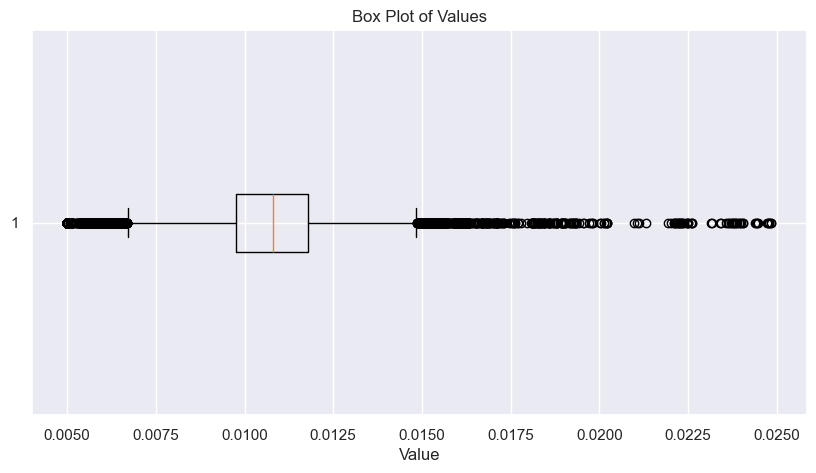

In [24]:
# Box Plot
plt.figure(figsize=(10, 5))
plt.boxplot(temp_df['RootPolicyStatusCtrlResponsePctle1sec'], vert=False)
plt.title('Box Plot of Values')
plt.xlabel('Value')
plt.show()

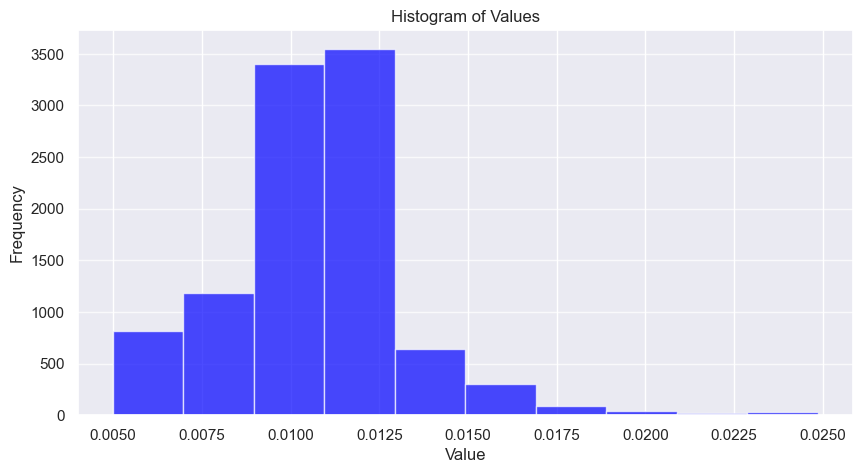

In [25]:
# Histogram
#temp_df['RootPolicyStatusCtrlResponsePctle1sec'] = temp_df['RootPolicyStatusCtrlResponsePctle1sec'] * 10

plt.figure(figsize=(10, 5))
plt.hist(temp_df['RootPolicyStatusCtrlResponsePctle1sec'], bins=10, alpha=0.7, color='blue')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()